# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix

# training
pipe = make_pipeline(StandardScaler(),SGDClassifier(random_state=0))
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(random_state=0))])

In [4]:
# metricas
def metricas(model,XX,YY):
    scores = cross_validate(model, XX, YY, 
                            scoring=['accuracy', 'precision','recall','f1'],
                            cv=50, n_jobs=-1, 
                            verbose=True)

    dd={}
    for key, val in scores.items():
        if key in ['fit_time', 'score_time']:
            continue
        name = " ".join(key.split('_')[1:])     
        dd[name] = {'value' : "{:.2f}".format(np.mean(val)), 'error' : "{:.2f}".format(np.std(val))}
    return pd.DataFrame(dd)   

# matriz de confusión
def confusion_matrix(model,XX,YY):
    plot_confusion_matrix(model, XX, YY,
                      cmap=plt.cm.Blues,
                      normalize='true');

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


,accuracy,precision,recall,f1
value,0.85,0.57,0.36,0.42
error,0.06,0.35,0.23,0.25


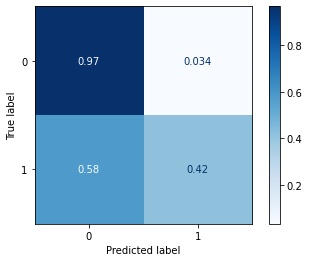

In [5]:
# conjunto de entrenamiento
confusion_matrix(pipe,X_train,y_train)
metricas(pipe,X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


,accuracy,precision,recall,f1
value,0.83,0.34,0.46,0.37
error,0.12,0.40,0.48,0.40


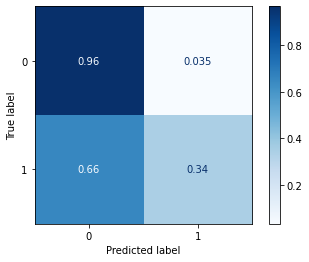

In [6]:
# conjunto de evaluación
confusion_matrix(pipe,X_test, y_test)
metricas(pipe,X_test,y_test)

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pipelines = []
pipelines.append(("Model 1", 
                  Pipeline([('Scaler', StandardScaler()),
                            ('SGDClassifier', 
                             SGDClassifier(learning_rate='optimal', random_state=0))])))
pipelines.append(("Model 2", 
                  Pipeline([('Scaler', StandardScaler()),
                            ('SGDClassifier', 
                             SGDClassifier(learning_rate='invscaling',eta0=1.0, random_state=0))])))
pipelines.append(("Model 3", 
                  Pipeline([('Scaler', StandardScaler()),
                            ('SGDClassifier', 
                             SGDClassifier(learning_rate='constant',eta0=1.0, random_state=0))])))

results_t = []
results_v = []
names = []
score_sd = []
skf = StratifiedKFold(n_splits=5)
metric_train = []
metric_test = []
params = {
    "SGDClassifier__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "SGDClassifier__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "SGDClassifier__penalty" : ["l2", 'elasticnet'],
    "SGDClassifier__eta0" : [0.5, 1.0, 1.5],
    "SGDClassifier__max_iter" : [10000],
}
for (name, model) in pipelines:
    my_model = GridSearchCV(model,param_grid=params,cv=skf)
    my_model.fit(X_train, y_train)
    predictions_train = my_model.predict(X_train) 
    predictions_test = my_model.predict(X_test)
    metric_train.append(metricas(my_model,X_train,y_train))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


In [8]:
def best_params(name,model):
    params = model.get_params()
    loss = params['SGDClassifier__loss']
    alpha = params['SGDClassifier__alpha']
    penalty = params['SGDClassifier__penalty']
    et0 = params['SGDClassifier__eta0']
    lr = params['SGDClassifier__learning_rate']
    return print(f'{name}: loss={loss}, alpha={alpha}, penalty={penalty}, et0={et0}, lr={lr}' )

In [9]:
for i,(name, model) in enumerate(pipelines):
    best_params(name, model)
    display(metric_train[i])

Model 1: loss=hinge, alpha=0.0001, penalty=l2, et0=0.0, lr=optimal


,accuracy,precision,recall,f1
value,0.87,0.65,0.29,0.38
error,0.05,0.42,0.24,0.28


Model 2: loss=hinge, alpha=0.0001, penalty=l2, et0=1.0, lr=invscaling


,accuracy,precision,recall,f1
value,0.87,0.69,0.29,0.39
error,0.05,0.41,0.23,0.27


Model 3: loss=hinge, alpha=0.0001, penalty=l2, et0=1.0, lr=constant


,accuracy,precision,recall,f1
value,0.82,0.41,0.30,0.32
error,0.07,0.36,0.25,0.27


In [10]:
# training best model
best_model = make_pipeline(StandardScaler(),SGDClassifier(loss='hinge', alpha=0.0001, penalty='l2', eta0=1.0, learning_rate='invscaling',random_state=0))
best_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(eta0=1.0, learning_rate='invscaling',
                               random_state=0))])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


,accuracy,precision,recall,f1
value,0.87,0.70,0.27,0.38
error,0.04,0.43,0.22,0.27


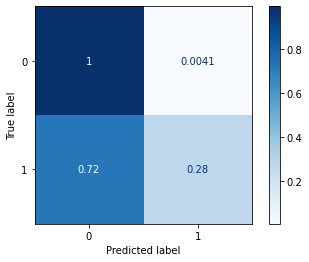

In [11]:
# conjunto de entrenamiento 
confusion_matrix(best_model,X_train,y_train)
metricas(best_model,X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


,accuracy,precision,recall,f1
value,0.88,0.27,0.23,0.24
error,0.06,0.44,0.39,0.39


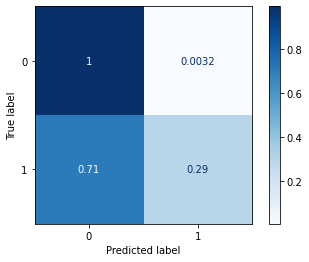

In [12]:
# conjunto de evaluación
confusion_matrix(best_model,X_test, y_test)
metricas(best_model,X_test,y_test)

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [13]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = make_pipeline(StandardScaler(),DecisionTreeClassifier(random_state=0))
dec_tree.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=0))])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished


,accuracy,precision,recall,f1
value,0.88,0.72,0.55,0.59
error,0.05,0.23,0.21,0.19


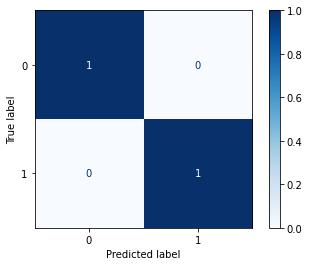

In [14]:
# conjunto de entrenamiento
confusion_matrix(dec_tree,X_train,y_train)
metricas(dec_tree,X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


,accuracy,precision,recall,f1
value,0.81,0.29,0.38,0.31
error,0.12,0.39,0.46,0.39


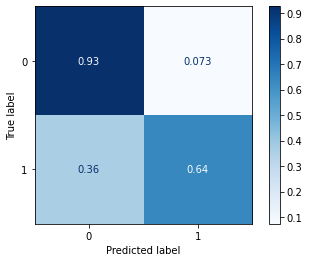

In [15]:
# conjunto de evaluación
confusion_matrix(dec_tree,X_test, y_test)
metricas(dec_tree,X_test,y_test)

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [16]:
pipelines = []
pipelines.append(("Model 1", 
                  Pipeline([('Scaler', StandardScaler()),
                            ('DecisionTreeClassifier', 
                             DecisionTreeClassifier(criterion='gini',
                                                    min_samples_leaf=30, random_state=0))])))
pipelines.append(("Model 2", 
                  Pipeline([('Scaler', StandardScaler()),
                            ('DecisionTreeClassifier', 
                             DecisionTreeClassifier(criterion='entropy',
                                                    min_samples_leaf=1, random_state=0))])))

results_v = []
names = []
score_sd = []
skf = StratifiedKFold(n_splits=5)
metric_train = []
metric_test = []
params = {'DecisionTreeClassifier__max_depth': [None, 5, 10, 15, 20, 25, 30],
          'DecisionTreeClassifier__min_samples_leaf': [1, 5, 10, 20, 30]
    
}
for (name, model) in pipelines:
    my_model = GridSearchCV(model,param_grid=params,cv=skf)
    my_model.fit(X_train, y_train)
    predictions_train = my_model.predict(X_train) 
    predictions_test = my_model.predict(X_test)
    metric_train.append(metricas(my_model,X_train,y_train))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


In [17]:
def best_params2(name,model):
    params = model.get_params()
    depth = params['DecisionTreeClassifier__max_depth']
    min_leaf = params['DecisionTreeClassifier__min_samples_leaf']
    criterion = params['DecisionTreeClassifier__criterion']
    return print(f'{name}: depth={depth}, min_leaf={min_leaf}, criterion={criterion}' )

In [18]:
for i,(name, model) in enumerate(pipelines):
    best_params2(name, model)
    display(metric_train[i])

Model 1: depth=None, min_leaf=30, criterion=gini


,accuracy,precision,recall,f1
value,0.88,0.75,0.45,0.54
error,0.05,0.29,0.22,0.22


Model 2: depth=None, min_leaf=1, criterion=entropy


,accuracy,precision,recall,f1
value,0.88,0.81,0.38,0.49
error,0.04,0.26,0.22,0.21


In [19]:
# training best model
best_model_dt = make_pipeline(StandardScaler(),DecisionTreeClassifier(criterion='entropy',max_depth=None,
                                                    min_samples_leaf=1, random_state=0))
best_model_dt.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=0))])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


,accuracy,precision,recall,f1
value,0.89,0.72,0.60,0.63
error,0.05,0.22,0.23,0.19


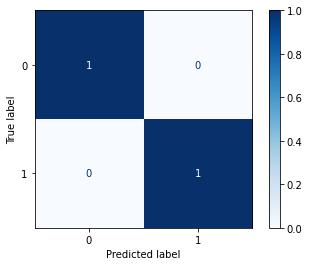

In [20]:
# conjunto de entrenamiento 
confusion_matrix(best_model_dt,X_train,y_train)
metricas(best_model_dt,X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


,accuracy,precision,recall,f1
value,0.88,0.27,0.23,0.24
error,0.06,0.44,0.39,0.39


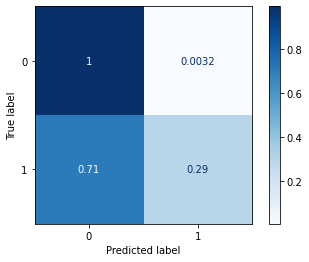

In [21]:
# conjunto de evaluación
confusion_matrix(best_model,X_test, y_test)
metricas(best_model,X_test,y_test)